In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import os, re
import cv2
import glob
import pathlib
import time
import datetime
from IPython import display
from PIL import Image

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

학습 내용
1. Augmentation 적용 (1) 데이터 불러오기
2. Augmentation 적용 (2) Augmentation 적용하기
3. Augmentation 적용 (3) 비교 실험하기
4. 심화 기법 (1) Cutmix Augmentation
5. 심화 기법 (2) Mixup Augmentation
6. 프로젝트: CutMix 또는 Mixup 비교 실험하기

루브릭
1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?
   - CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.

2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?
   - 각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음

3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?
   - 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

# 1. Augmentation 적용

## (1) 데이터 불러오기

In [2]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', split=['train', 'test'], shuffle_files=True, with_info=True)

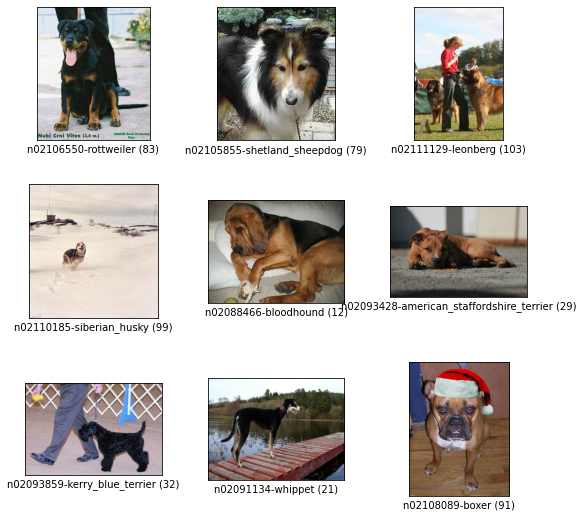

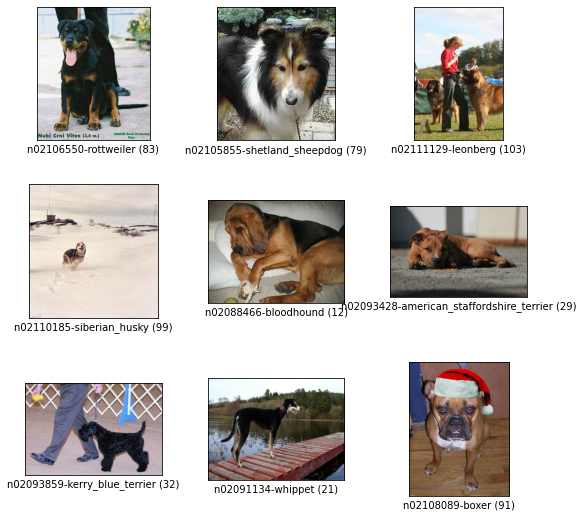

In [3]:
tfds.show_examples(ds_train, ds_info)

## (2) Augmentation 적용하기
텐서플로우 Random Augmentation API 사용하기

### 1) 데이터 전처리

In [4]:
def normalize_and_resize_img(image, label):
    # Normalizes images: 'uint8' -> 'float32'
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [5]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [6]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2       # 입력 데이터를 처리할 때 두 개의 병렬 스레드를 사용하여 처리
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,               # augment 함수 적용 (테스트 데이터셋에는 적용하지 않아야 함)
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)       # shuffle 함수 적용 (테스트 데이터셋에는 적용하지 않아야 함)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 2) Random Augmentation 직접 구현하기

In [7]:
# make random augment function (augment2)
def augment2(image, label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

## (3) 비교실험 하기

In [8]:
# augmentation을 적용한 데이터를 학습시킨 모델 vs. 적용하지 않은 데이터를 학습시킨 모델의 성능

# 아래 코드는 텐서플로우 케라스의 ResNet50 중 imagenet으로 훈련된 모델을 불러옵니다. 
# include_top은 마지막 fully connected layer를 포함할지 여부입니다.
# 해당 레이어를 포함하지 않고 생성하면 특성 추출기(feature extractor) 부분만 불러와 
# 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있습니다. 
# 이렇게 하는 이유는 이미지넷(ImageNet)과 우리의 테스트셋이 서로 다른 클래스를 가지므로,
# 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수) 또한 다르기 때문입니다.

In [9]:
num_classes = ds_info.features["label"].num_classes

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

In [10]:
# Augmentation을 적용한 데이터셋으로 학습시킬 ResNet을 하나 더 만들어 줌 (이름만 다르고 resnet50, aug_resnet50이 똑같음)

In [11]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

In [12]:
# 텐서플로우 데이터셋에서 불러온 데이터에 하나는 
# apply_normalize_on_dataset()에서 with_aug를 False로 주어 augmentation이 적용되지 않도록 하고, 
# 다른 하나는 True로 주어 augmentation이 적용되도록 합니다.


# as_supervised=True로 지정하면, 
# 데이터셋에서 (input, label) 쌍으로 구성된 데이터를 반환합니다. 
# 즉, 반환되는 데이터는 튜플 형태로 (input_data, label_data)로 구성됩니다.

# 반면에, as_supervised=False로 지정하면, 
# 데이터셋에서 레이블이 없는 형태의 입력 데이터만을 반환합니다. 
# 즉, 입력 데이터만을 반환하게 됩니다. 
# 이 경우, 데이터셋에서 레이블 정보를 따로 로드하여 처리해야 합니다.

# 따라서, as_supervised=False로 지정되었다면, 
# 로드된 데이터셋에서는 입력 데이터만을 담고 있는 tf.data.Dataset 객체가 반환됩니다.

In [13]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', split=['train', 'test'], as_supervised=True,
                                         shuffle_files=True, with_info=True)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [14]:
# 이제 두 개 모델에 각각 augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋을 학습시키고, 검증을 진행합니다.

# 아래 학습은 EPOCH=20으로 진행시 GPU 기반으로 3~4시간 가량의 시간이 소요됩니다. 
# Augmentation 적용 효과를 명확히 검증하기 위해서는 최소 이정도의 학습이 진행되어야 하지만,
# 원활한 학습 진행을 위해서 EPOCH=3 정도로 진행해 보기를 권합니다. 
# 하지만 실제 프로젝트 단계에서는 꼭 충분한 학습이 진행되어야 합니다.

In [15]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 1

resnet50.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                 loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug,   # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

750/750 [==============================] - 168s 209ms/step - loss: 2.2386 - accuracy: 0.4389 - val_loss: 3.3133 - val_accuracy: 0.2177


In [16]:
aug_resnet50.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                     loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

750/750 [==============================] - 167s 214ms/step - loss: 2.2844 - accuracy: 0.4248 - val_loss: 2.9370 - val_accuracy: 0.2727


In [17]:
# 훈련 과정을 시각화 해봅시다.

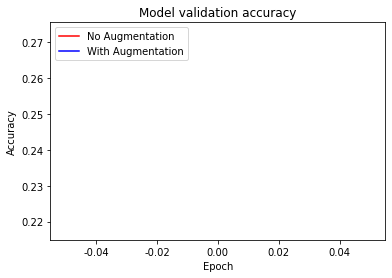

In [18]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

In [19]:
# 조금 더 확대해 살펴봅시다.

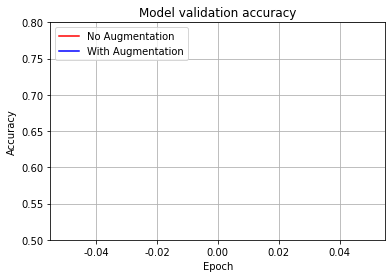

In [20]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요.
#plt.ylim(0.72, 0.76)   # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

In [21]:
# 참고로, EPOCH=20으로 수행해 본 두 모델의 훈련 과정 시각화한 내용은 아래 그림과 같습니다. 
# Augmentation 적용한 경우가 보다 천천히 학습되지만, 
# EPOCH 10을 전후해서 aug_resnet50의 accuracy가 더 높게 형성되는 것을 확인할 수 있습니다.

## (4) 심화 기법 (1) Cutmix Augmentation

In [22]:
# 이름인 CutMix를 보고 유추할 수 있듯 이미지 데이터를 자르고 섞는다고 생각할 수 있습니다.
# CutMix는 이미지를 섞는 부분과 섞은 이미지에 맞추어 라벨을 섞는 부분을 포함합니다. 
# 이제 한 부분씩 구현해 보겠습니다.

### 1) 이미지 섞기

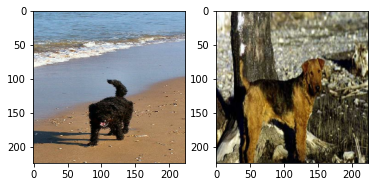

In [23]:
# 데이터셋에서 이미지 2개를 가져옴
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [24]:
# 두 개의 이미지를 얻었습니다.

# 이 중 첫 번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두 번째 이미지 b가 있을 때, 
# a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수를 먼저 구현해 봅시다.

# 이번 노드에서는 이미지 a, b가 모두 (224, 224)로 resize되어 
# 두 이미지의 width, height가 같은 경우로 가정할 수 있지만, 
# CutMix 공식 repo에서는 width, height가 다르더라도 가변적으로 적용할 수 있도록 구현되어 있기 때문에,
# 임의의 이미지 사이즈에 대해서도 유연하게 대응 가능하도록 구현해 보겠습니다.

In [25]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(130, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(199, shape=(), dtype=int32)


In [26]:
# 바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 
# 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현해 봅시다.

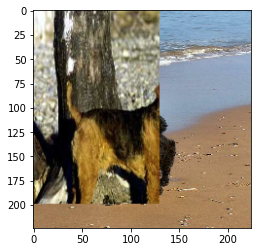

In [27]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :]              # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]        # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :]  # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

### 2) 라벨 섞기

In [28]:
# 이미지를 섞었다면 라벨도 이에 맞게 섞어주어야 합니다. 
# 그림에서 볼 수 있듯, 우리가 강아지와 고양이의 이미지를 섞었다면 라벨 또한 적절한 비율로 섞여야 합니다.

# CutMix에서는 면적에 비례해서 라벨을 섞어줍니다. 
# 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더해줍니다. 
# 예를 들어 A 클래스를 가진 원래 이미지 image_a와 B 클래스를 가진 이미지 image_b를 섞을 때 
# image_a를 0.4만큼 섞었을 경우, 0.4만큼의 클래스 A, 0.6만큼의 클래스 B를 가지도록 해줍니다.
# 이때 라벨 벡터는 보통 클래스를 표시하듯 클래스 1개만 1의 값을 가지는 원-핫 인코딩이 아니라 
# A와 B 클래스에 해당하는 인덱스에 각각 0.4, 0.6을 배분하는 방식을 사용합니다.

# 위에서 섞인 이미지 두 가지에 대하여 라벨을 만들 때 
# 적절한 비율로 라벨을 합쳐주는 함수를 구현해 봅시다.

In [29]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.48441488, 0.        ,
       0.5155851 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [30]:
# 위에서 구현한 두 함수 mix_2_images()와 mix_2_label()을 활용하여 
# 배치 단위의 cutmix() 함수를 구현해 봅시다.

In [31]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## (5) 심화 기법 (2) Mixup Augmentation

In [32]:
# Mixup은 앞에서 보여드린 CutMix보다 간단하게 이미지와 라벨을 섞어줍니다. 
# 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 CutMix보다 구현이 간단

# 두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 
# 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 됩니다.

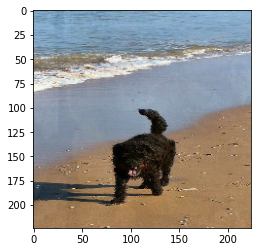

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.9491092 0.        0.0508908 0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

In [33]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image = (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [34]:
# 그러면 위에서 구현한 함수를 활용하여 배치 단위의 mixup() 함수를 구현해 봅시다.

In [35]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# 2. Project_CutMix_vs_Mixup

In [36]:
# 지금까지 기본적인 augmentation 방법을 적용해 모델을 훈련시키고, 
# 최신 augmentation 기법을 배워 보았습니다.

# 이번에는 최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련시켜 봅시다. 
# 데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시켜 주세요. 
# 결과를 수치화하고 비교하는 것도 잊지 마세요!

## (1) Augmentation을 적용한 데이터셋 만들기

In [37]:
# 이전 스텝과 아래 코드를 참고하여 
# 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

### 1) 데이터 불러오기

In [150]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', split=['train', 'test'], shuffle_files=True, with_info=True)

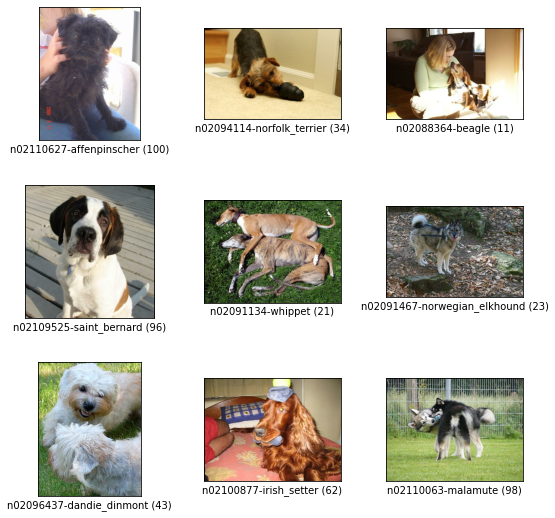

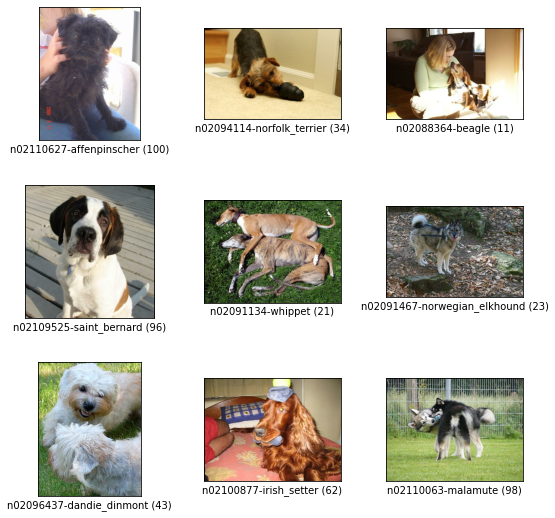

In [151]:
tfds.show_examples(ds_train, ds_info)

### 2) 데이터 전처리

In [152]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )     
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )   
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [153]:
# def normalize_and_resize_img(image, label):
#     # Normalizes images: `uint8` -> `float32`
#     image = tf.image.resize(image, [224, 224])
#     return tf.cast(image, tf.float32) / 255., label

# def augment(image, label):
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_brightness(image, max_delta=0.2)
#     image = tf.clip_by_value(image, 0, 1)
#     return image, label

# def onehot(image, label):
#     label = tf.one_hot(label, num_classes)
#     return image, label

# def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
#     ds = ds.map(
#         normalize_and_resize_img, 
#         num_parallel_calls=2
#     )
#     if not is_test and with_aug:
#         ds = ds.map(
#             augment
#         )
#     ds = ds.batch(batch_size)
#     if not is_test and with_cutmix:
#         ds = ds.map(
#             cutmix,
#             num_parallel_calls=2
#         )     
#     else:
#         ds = ds.map(
#             onehot,
#             num_parallel_calls=2
#         )
#     if not is_test and with_mixup:
#         ds = ds.map(
#             mixup,
#             num_parallel_calls=2
#         )     
#     else:
#         ds = ds.map(
#             onehot,
#             num_parallel_calls=2
#         )    
#     if not is_test:
#         ds = ds.repeat()
#         ds = ds.shuffle(200)
#     ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
#     return ds

### 3) Random Augmentation 직접 구현하기

In [154]:
# make random augment function (augment2)
def augment2(image, label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

## (2) 모델 만들기

In [155]:
# 앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 
# 모델은 ResNet-50을 사용합시다.

In [156]:
num_classes = ds_info.features["label"].num_classes

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

In [157]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

In [158]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', split=['train', 'test'], as_supervised=True,
                                         shuffle_files=True, with_info=True)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

## (3) 모델 훈련하기

In [141]:
# 모델을 훈련시켜 주세요.
# 주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 
# 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 
# sparse_categorical_crossentropy() 대신 
# categorical_crossentropy()를 사용해 주세요!

In [142]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 1

resnet50.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                 loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug,   # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

KeyboardInterrupt: 

In [123]:
aug_resnet50.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                     loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

750/750 [==============================] - 163s 208ms/step - loss: 2.2902 - accuracy: 0.4260 - val_loss: 3.3696 - val_accuracy: 0.2053


## (4) 훈련 과정 시각화하기

In [124]:
# 훈련 과정을 시각화 해봅시다.

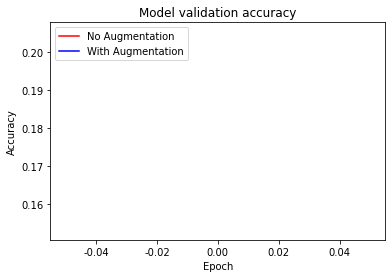

In [125]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

In [126]:
# 조금 더 확대해 살펴봅시다.

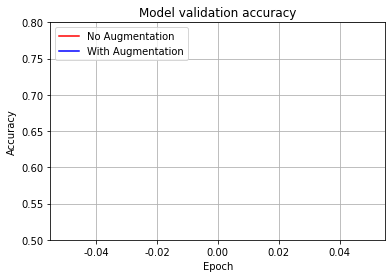

In [127]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요.
#plt.ylim(0.72, 0.76)   # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

## (5) Augmentation에 의한 모델 성능 비교

In [73]:
# No Augmentation, 기본 Augmentation, 
# 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 
# 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, 
# Augmentation 방법들의 영향도에 대해 분석해 보세요.

### 1) Cutmix Augmentation

#### - (1) 이미지 섞기

In [159]:
# 데이터셋에서 이미지 2개를 가져옴
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

        
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)


# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :]              # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]        # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :]  # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)

#### - (2) 라벨 섞기

In [160]:
# mix two labels
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max)


def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

#### - (3) ds_train_cutmix_aug

In [161]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16

ds_train_cutmix_aug = (
    ds_train_no_aug.shuffle(200)
    .map(cutmix, num_parallel_calls=AUTO)
#     .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [162]:
ds_train_cutmix_aug

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>

In [163]:
# class_names = ds_info.features["label"].names

# image_batch, label_batch = next(iter(ds_train_cutmix_aug))
# plt.figure(figsize=(10, 10))
# for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.title(class_names[label_batch[i].numpy()[0]])
#     plt.imshow(image_batch[i])
#     plt.axis("off")

In [164]:
# image_batch, label_batch = next(iter(ds_train_cutmix_aug))
# plt.figure(figsize=(10, 10))
# for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.title(class_names[np.argmax(label_batch[i])])
#     plt.imshow(image_batch[i])
#     plt.axis("off")

#### - (4) 모델 만들기

In [165]:
num_classes = ds_info.features["label"].num_classes

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

In [166]:
ds_train_cutmix_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

TypeError: in user code:

    /tmp/ipykernel_3891/1614326512.py:13 onehot  *
        label = tf.one_hot(label, num_classes)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:4349 one_hot
        return gen_array_ops.one_hot(indices, depth, on_value, off_value, axis,
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/gen_array_ops.py:6251 one_hot
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:628 _apply_op_helper
        _SatisfiesTypeConstraint(base_type,
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:59 _SatisfiesTypeConstraint
        raise TypeError(

    TypeError: Value passed to parameter 'indices' has DataType float32 not in list of allowed values: uint8, int32, int64


#### - (5) 모델 훈련하기

In [ ]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 1

aug_resnet50.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                     loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet50_cutmix_aug = aug_resnet50.fit(
    ds_train_cutmix_aug, # cutmix augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

#### - (6) 훈련 과정 시각화하기 (3가지)

In [ ]:
# 훈련 과정을 시각화 해봅시다.

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix Augmentation'], loc='upper left')
plt.show()

In [ ]:
# 조금 더 확대해 살펴봅시다.

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요.
#plt.ylim(0.72, 0.76)   # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

### 2) Mixup Augmentation

#### - (1) Mixup Augmentation

In [ ]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image = (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)


def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

#### - (2) ds_train_mixup_aug

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16

ds_train_cutmix_aug = (
    ds_train_no_aug.shuffle(200)
    .map(mixup, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [ ]:
# ds_train_mixup_aug = (
#     ds_train_aug.shuffle(200)
#     .map(mixup, num_parallel_calls=AUTO)
#     .batch(BATCH_SIZE=16)
#     .prefetch(AUTO)
# )

In [ ]:
image_batch, label_batch = next(iter(ds_train_mixup_aug))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")

#### - (3) 모델 만들기

In [ ]:
num_classes = ds_info.features["label"].num_classes

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

In [ ]:
ds_train_mixup_aug = apply_normalize_on_dataset(ds_train_mixup_aug, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

#### - (4) 모델 훈련하기

In [ ]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 3

aug_resnet50.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                     loss='categorical_crossentropy', metrics=['accuracy'])
# sparse_categorical? 아님 그냥 categorical???????????????

history_resnet50_mixup_aug = aug_resnet50.fit(
    ds_train_mixup_aug, # mixup augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

#### - (5) 훈련 과정 시각화하기 (4가지)

In [ ]:
# 훈련 과정을 시각화 해봅시다.

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix Augmentation', 'With Mixup Augmentation'], loc='upper left')
plt.show()

In [ ]:
# 조금 더 확대해 살펴봅시다.

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix Augmentation', 'With Mixup Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요.
#plt.ylim(0.72, 0.76)   # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

#### - (1) No Augmentation

#### - (2) 기본 Augmentation

#### - (3) CutMix Augmentation

#### - (4) Mixup Augmentation

# 3. Conclusion

# 4. References

[1] https://lms.aiffel.io/course/405/node/465